In [31]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
import cv2 as cv
from IPython.display import Image
from IPython.display import Video
import os

N = 256 
M = 256

def Bilinear(tex, x, y):
    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)
    oxf, oyf = 1.0-xf, 1.0-yf
    return tex[xi, yi]*oxf*oyf + tex[xi+1, yi]*xf*oyf + tex[xi, yi+1]*oxf*yf + tex[xi+1, yi+1]*xf*yf

def CubicHermit(x):
    x2 = x * x
    x3 = x2 * x
    return [-0.5 * x3 + x2 - 0.5 * x, 1.5 * x3 - 2.5 * x2 + 1.0, -1.5 * x3 + 2.0 * x2 + 0.5 * x, 0.5 * x3 - 0.5 * x2]

def CubicInterp(tex, x, y):
    xi, yi = tf.floor(x), tf.floor(y)
    xf, yf = x-xi, y-yi
    xi, yi = tf.int(xi), tf.int(yi)

    wx = CubicHermit(xf)
    wy = CubicHermit(yf)

    valueY = 0
    for j in range(-1, 3):
        valueX = 0
        for i in range(-1, 3):
            valueX = valueX + tex[xi + i, yi + j] * wx[i + 1]
        valueY = valueY + valueX * wy[j + 1]
    return valueY

def EulerAdvection(vx, vy, dt):
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)
    x1, y1 = x - vx*dt, y - vy*dt
    return x1, y1

def RK4Advection(vx, vy, dt):
    i, j = vx.indices
    x, y = tf.float(i), tf.float(j)

    x1, y1 = x - vx*dt/2.0, y - vy*dt/2.0
    vx1, vy1 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1)

    x2, y2 = x - vx1*dt/2.0, y - vy1*dt/2.0
    vx2, vy2 = Bilinear(vx, x2, y2), Bilinear(vy, x2, y2)

    x3, y3 = x - vx2*dt, y - vy2*dt
    vx3, vy3 = Bilinear(vx, x3, y3), Bilinear(vy, x3, y3)

    x4, y4 = x - (vx + 2.0*vx1 + 2.0*vx2 + vx3)*dt/6.0, y - (vy + 2.0*vy1 + 2.0*vy2 + vy3)*dt/6.0
    return x4, y4

def SemiLagrange(vx, vy, pressure, dt):
    # advect velocity
    #x1, y1 = RK4Advection(vx, vy, dt)
    x1, y1 = EulerAdvection(vx, vy, dt)

    #vx = CubicInterp(vx, x1, y1)
    #vy = CubicInterp(vy, x1, y1)
    #pressure = CubicInterp(pressure, x1, y1)
    vx = CubicInterp(vx, x1, y1)
    vy = CubicInterp(vy, x1, y1)
    #pressure = Bilinear(pressure, x1, y1)

    return [vx, vy, pressure]

def BFECC(vx, vy, pressure, dt):
    i, j = vx.indices
    x, y = tf.float(i), tf.float(j)
    
    # advect backwards
    x1, y1 = x - vx*dt, y - vy*dt
    vx1, vy1 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1)

    # advect forwards
    x2, y2 = x + vx*dt, y + vy*dt
    vx2, vy2 = Bilinear(vx1, x2, y2), Bilinear(vy1, x2, y2)

    # compute backwards forwards error correction
    vx = vx + (vx - vx2)*0.5
    vy = vy + (vy - vy2)*0.5

    # advect corrected backwards
    vx3, vy3 = Bilinear(vx, x1, y1), Bilinear(vy, x1, y1)

    return [vx3, vy3, pressure]

def Jacobi(pressure, div):
    i, j = pressure.indices

    # pressure solve
    pressure = (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div) / 4.0

    return pressure

def Smoothstep(edge0, edge1, x):
    x = (x - edge0) / (edge1 - edge0)
    x = tf.clamp(x, 0.0, 1.0)
    return x * x * (3.0 - 2.0 * x)
    
def FluidTest():
    vx = tf.input([N, M], tf.float32)
    vy = tf.input([N, M], tf.float32)
    pressure = tf.input([N, M], tf.float32)

    dt = 1.0
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)

    vx, vy, pressure = SemiLagrange(vx, vy, pressure, dt)
    
    # add source
    source = 0.26*tf.exp(-((x-N/5.0)**2.0 + (y-2.0*M/3.0)**2.0)/100.0)
    source = source - 0.25*tf.exp(-((x-4.0*N/5.0)**2.0 + (y-M/3.0)**2.0)/100.0)
    vx = vx + source

    edge = 1.0 - tf.float((i < 2) | (i > N-3) | (j < 2) | (j > M-3))
    vx = vx * edge
    vy = vy * edge

    # pressure solve
    # compute divergence
    div = (vx[i+1, j] - vx[i-1, j] + vy[i, j+1] - vy[i, j-1]) / 2.0

    # pressure solve
    for it in range(12):
        pressure = pressure * edge
        pressure = Jacobi(pressure, div)
    
    # subtract pressure gradient
    gradx = (pressure[i+1, j] - pressure[i-1, j])*1.0
    grady = (pressure[i, j+1] - pressure[i, j-1])*1.0
    vx = vx - gradx
    vy = vy - grady

    mag = 0.2*tf.sqrt(vx*vx + vy*vy)

    r, g, b = 255.0*Smoothstep(0.0, 0.33, mag), 255.0*Smoothstep(0.33, 0.66, mag), 255.0*Smoothstep(0.66, 1.0, mag)

    return [vx, vy, pressure, r, g, b]


tf.initialize(tf.cpu, "H:/cl_compile.bat /O2 /fp:fast /openmp:experimental")
fluid = tf.program(FluidTest)

dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2
dim =  2


In [32]:
VX = tf.memory(np.zeros((N, M)))
VY = tf.memory(np.zeros((N, M)))
PRESSURE = tf.memory(np.zeros((N, M)))

In [33]:
#do a few steps and measure performance by timing every 100 steps
start = time.time()

file_path = 'H:/TestVideos/fluid.gif'
writer = imageio.get_writer(file_path, fps=30, loop=0)

#use opencv to write is as video too
video_path = 'H:/TestVideos/fluid.mp4'
fourcc = cv.VideoWriter_fourcc(*'H264')
video = cv.VideoWriter(video_path, fourcc, 30, (N, M))

for i in range(200):
    VX, VY, PRESSURE, R, G, B = fluid(VX, VY, PRESSURE)

    if i % 5 == 0:
        color = np.stack((R.numpy, G.numpy, B.numpy), axis=2)
        color_rgb = color.astype(np.uint8)
        writer.append_data(color_rgb)
        video.write(color_rgb)

    if i % 30 == 9:
        print("Iteration: " + str(i+1) + ", IPS: " + str(30.0/(time.time()-start)))
        start = time.time()

print("Used memory: " + str(tf.used_memory()*4.0/1024.0/1024.0) + " MB")

writer.close()
video.release()

Iteration: 10, IPS: 127.6597609723434
Iteration: 40, IPS: 612.2386302263008
Iteration: 70, IPS: 638.298804861717
Iteration: 100, IPS: 625.0049422575438
Iteration: 130, IPS: 638.2955669522606
Iteration: 160, IPS: 624.9925246735443
Iteration: 190, IPS: 666.6761329017013
Used memory: 6.75 MB


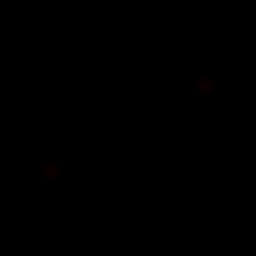

In [34]:
from IPython.display import Image
Image(file_path)

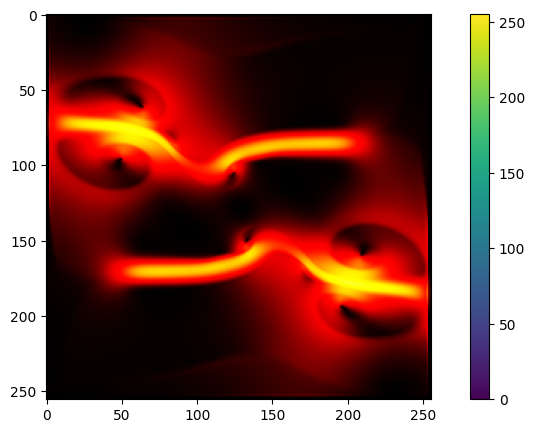

In [35]:
# plot color_rgb
Rnp = R.numpy
Gnp = G.numpy
Bnp = B.numpy
color = np.stack((Rnp, Gnp, Bnp), axis=-1)
color_rgb = color.astype(np.uint8)
plt.figure(figsize=(10,5))
plt.imshow(color_rgb)
plt.colorbar()
plt.show()


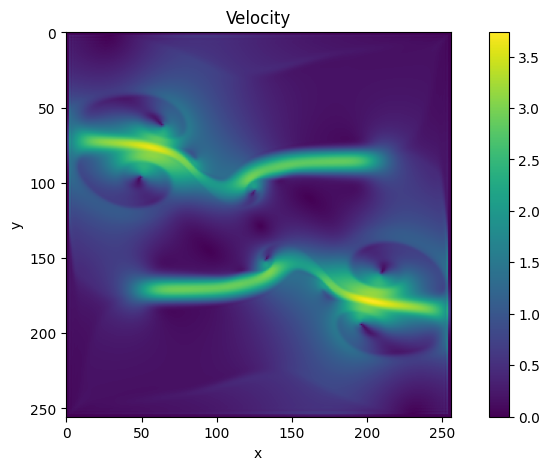

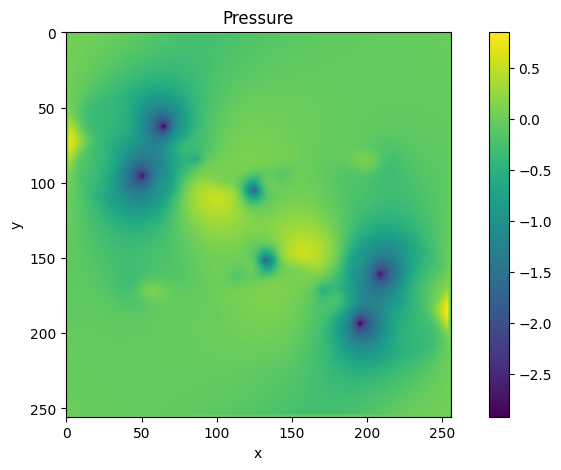

In [36]:
# plot the final velocity with colorbar
plt.figure(figsize=(10,5))
plt.imshow(np.sqrt(VX.numpy**2.0 + VY.numpy**2.0))
plt.colorbar()
plt.title('Velocity')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot the final pressure with colorbar
plt.figure(figsize=(10,5))
plt.imshow(PRESSURE.numpy)
plt.colorbar()
plt.title('Pressure')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [37]:
# export velocity as a png image 
from PIL import Image

Rnp = R.numpy
Gnp = G.numpy
Bnp = B.numpy
color = 0.1*np.stack((Rnp, Gnp, Bnp), axis=-1)
color_rgb = color.astype(np.uint8)

img = Image.fromarray(color_rgb, 'RGB')

img.save('H:/TestVideos/fluid_velocity.png')

